In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## 4-1. 画像処理と畳込み演算


### 画像データの形式

#### 白黒の画像データ
画像をデータとして扱うとはどういうことでしょうか。有名な画像処理用のデータセットである、MNISTというのを使って説明してみます。tensorflowにダウンロード用のコマンドが用意されているので、それを使ってみましょう。
> 各ライブラリにこのような有名なデータセットをダウンロードするコマンドがあるのですが、例えばtensorflowでMNISTをダウンロードした後pytorchでもう一度ダウンロードすると、同じデータを二回ダウンロードする羽目になります。それが嫌な場合は自分でバイナリファイルをダウンロードして、各ライブラリのAPIに従ってファイルから開く、という手続きを踏んでください。といっても、MNISTくらいのデータサイズなら二個入れても問題ないと思われますが。

In [2]:
mnist = tf.keras.datasets.mnist 

In [270]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0

ダウンロードされていない場合、上の一行目の実行で自動的にダウンロードが始まります。

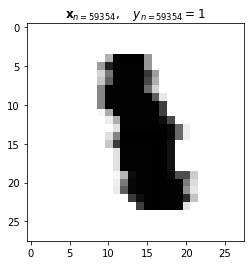

In [271]:
n = np.random.randint(len(y_mnist_train))
plt.title(r"${\bf x}_{n=%d},\quad y_{n=%d}=%d$"%(n, n, y_mnist_train[n]))
plt.imshow(x_mnist_train[n], cmap='gray_r'); plt.show()

こんな風に、`x_train[n]`には手書き文字画像が、`y_train[n]`にはその画像のラベルが格納されているのがわかります。この画像の正体は、**28x28行列** です：

In [272]:
x_mnist_train[n].shape

(28, 28)

もっと明示的に表示してみると


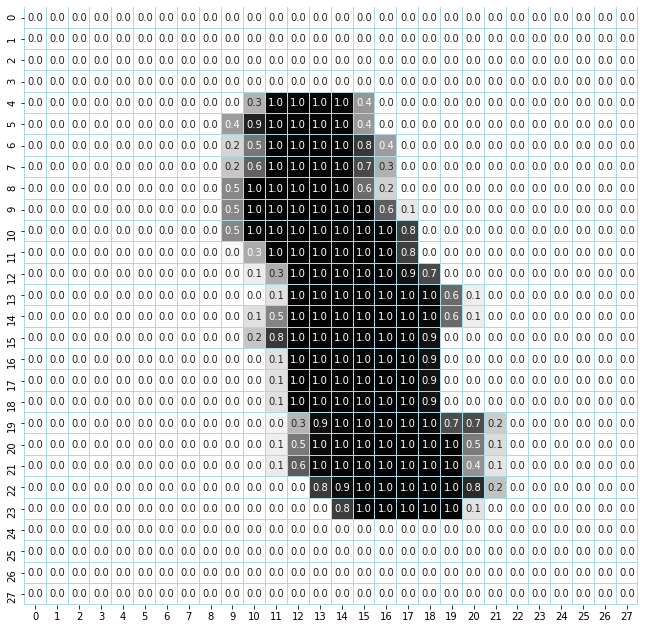

In [273]:
plt.figure(figsize=(11,11))
sns.heatmap(x_mnist_train[n], annot=True, cmap='gray_r', fmt="1.1f", linecolor='lightblue', linewidths=.01, cbar=False)
plt.show()

こんな風になっています。この ${\bf x}_n$ をデータとして取り扱うとき、敢えて並び替えて $28^2 = 784$ 次元ベクトルとして描くと

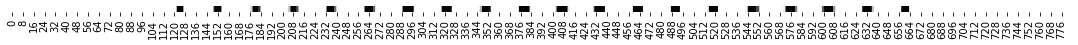

In [274]:
plt.figure(figsize=(19,.1))
sns.heatmap(x_mnist_train[n].reshape(1, 28**2), annot=False, cmap='gray_r', cbar=False)
plt.show()

こんな風にバーコード状になり、「画像」としての情報が落ちてしまっている気がします。なので、画像を表す ${\bf x}_n$ はベクトル表示するよりも、 $28 \times 28$ の行列、ないしテンソルとして取り扱ったほうが良いでしょう。

#### カラー画像のデータ
MNISTは白黒（グレイスケール）の画像データでしたが、カラー画像はどのような形式で表現されるでしょうか？こちらも代表的なデータセット、CIFAR-10というのを使って観察してみましょう：

In [76]:
cifar10 = tf.keras.datasets.cifar10

In [275]:
(x_cifar10_train, y_cifar10_train), (x_cifar10_test, y_cifar10_test) = cifar10.load_data()
x_cifar10_train, x_cifar10_test = x_cifar10_train / 255.0, x_cifar10_test / 255.0

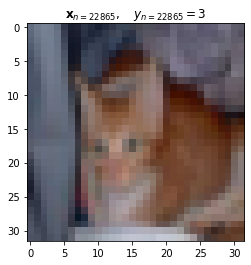

In [279]:
n = np.random.randint(len(y_cifar10_train))
plt.title(r"${\bf x}_{n=%d},\quad y_{n=%d}=%d$"%(n, n, y_cifar10_train[n]))
plt.imshow(x_cifar10_train[n]); plt.show()

サイズは $32 \times 32$ であることが見て取れます。テンソルの型を見てみると

In [280]:
x_cifar10_train[n].shape

(32, 32, 3)

$32 \times 32 \times 3$ であることがわかります。これは、**RGB** 表現と呼ばれるカラー画像のフォーマットであり、最初の $32 \times 32$ 成分はMNIST同様に画像の座標(各点の正方形は**ピクセル**と呼ばれます)を、最後の3成分は、それぞれ順にRed, Green, Blueを表現しています。この自由度を **チャネル(channel)** といいます。RGB形式以外にも幾つかフォーマットがあり、3チャネルではないようなものもあります。まとめると
- 1枚のカラー画像＝数枚のグレイスケール画像

と見なせるということです：

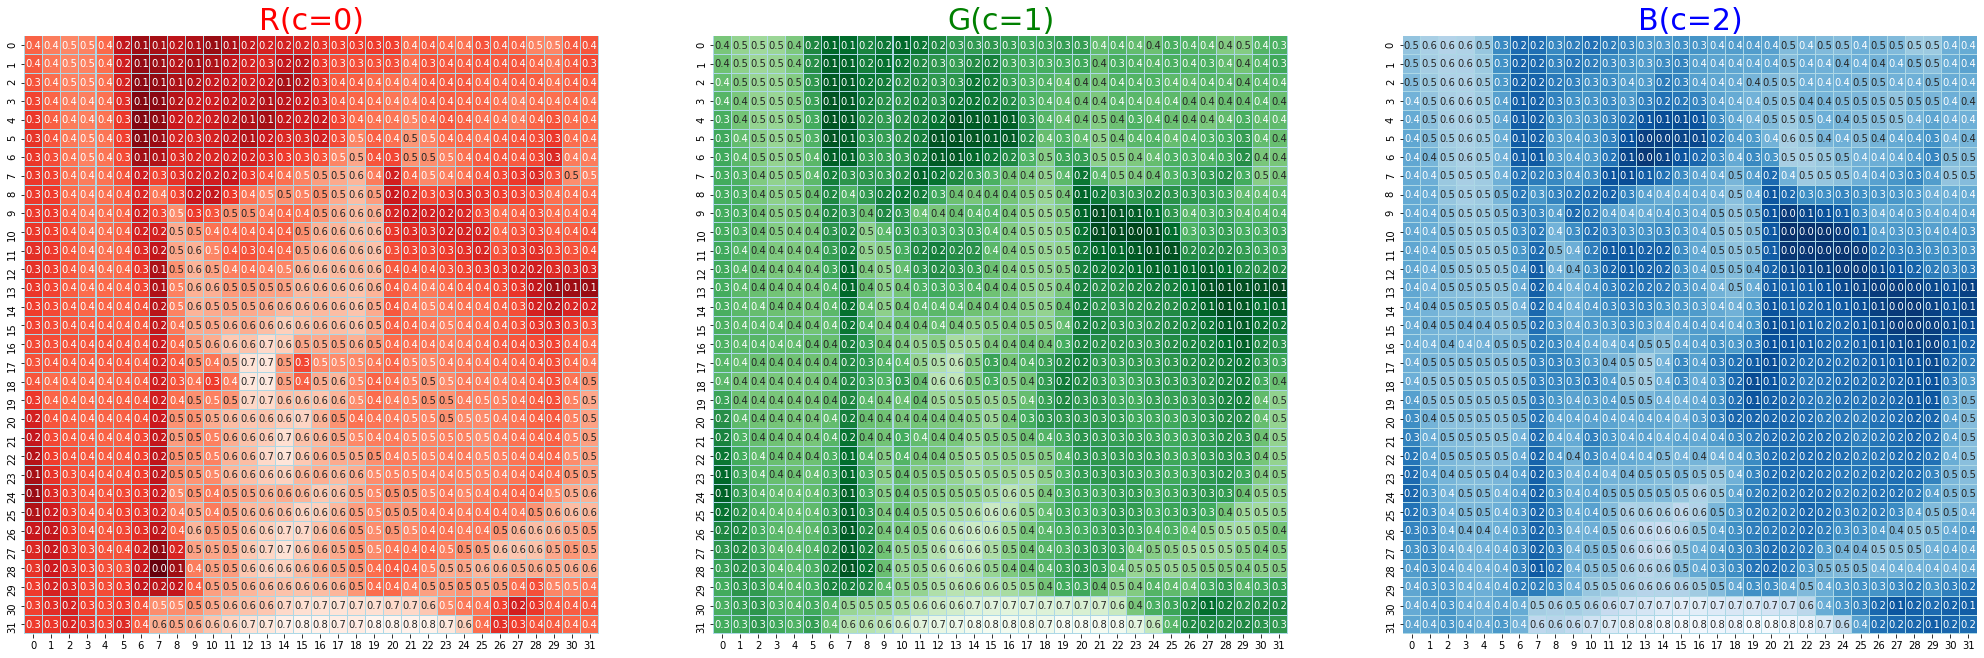

In [318]:
RGB = ['Reds_r', 'Greens_r', 'Blues_r']; colors=['red', 'green', 'blue']
fig = plt.figure(figsize=(35,11))
for c in range(3):
    fig.add_subplot(1,3,c+1); fig.axes[c].set_title(RGB[c][0]+"(c=%d)"%c, color=colors[c], fontsize=30)
    sns.heatmap(x_cifar10_train[n][:,:,c], annot=True, cmap=RGB[c], fmt="1.1f", linecolor='lightblue', linewidths=.01, cbar=False)
plt.show() # ちょっと時間かかります

カラー画像はつまり 

$$
{\bf x} = (x_{ij}^c), \quad i\in [0,1,\dots, L_x-1], \quad j\in[0,1,\dots,L_y-1], \quad c \in [0,1, \dots, L_c-1]
$$

の三成分テンソルということになりますが、これを並び替えて1列のベクトルにすると、やはりバーコード状になってしまい、空間的な情報の他に**色に関する情報も落ちてしまいます**。

### 画像データに対する演算

#### 通常の線形変換をかけてみる
画像をニューラルネットに入れると何が起こるか考えるのに、まず前の節で説明した`tf.keras.layers.Dense`をかけることを考えてみます。この変換を適応するためには一旦、画像をバーコード状のベクトルにした後、変換にかけ次元を少し減らし、もとの画像に戻す、というのをやってみます：

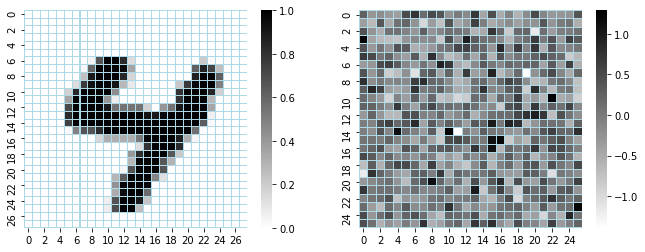

In [355]:
x = x_mnist_train[n].astype(np.float32)
l = tf.keras.layers.Dense(units=26**2)
y = l(x.reshape(1, 28**2)).numpy().reshape(26,26)

fig = plt.figure(figsize=(11, 4))
fig.add_subplot(121); sns.heatmap(x, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
fig.add_subplot(122); sns.heatmap(y, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
plt.show()

画像としての情報がなくなってしまっているのがわかります。

#### 畳み込み演算（グレイスケール$\to$グレイスケール）
画像データ $\bf x$ は空間的に情報が埋め込まれており、これまでどおりのdenseな線形変換では特徴量を抽出するのに冗長だと思われます。このようなときに使われるのが **畳み込み演算** と呼ばれる線形変換で、線形変換を行列として書くなら
- スパースかつ
- 重みを共有しているもの

として表現できます。絵的に表現すると以下のようになります：

![alt](conv.jpg)

○は画像の1ピクセルを表し、□はスカラー値を表します。□が集まった小さい「画像」のようなものを **フィルター** といい、これが畳み込み( **convolution** )演算を定義します。畳み込み演算の出力も行列やテンソルの形式を取り、いわば「画像に特化した線形変換」をしていると考えることができます。数式で書くと、フィルターを行列として表現したものを $w_{\Delta i, \Delta j}$ とし、入力（白黒）画像を $x_{i,j}$ 出力を $y_{I,J}$ とすると

$$
y_{I, J}=
\sum_{\Delta i = 1}^{k_x}
\sum_{\Delta j = 1}^{k_y}
w_{\Delta i, \Delta j}
x_{(s_x(I-1) + \Delta i), (s_y(J-1) + \Delta j)} + b =: C_{w, b}(x_{i, j})
$$

と表せます。ここで $s_x, s_y$ は何個飛ばしでフィルターをかけるかのパラメータで、 **ストライド** と呼ばれます。また $l_x, l_y$ はフィルターのサイズで、**カーネルサイズ** などと呼ばれます。
> パラメータの数がdenseな線形変換にくらべて、$28^2 \times 26^2 + 26^2 \to 3^2 + 1$ に減っているのに注意してください。パラメータ数が減るので、denseに比べ過剰適合も抑制されると期待できます。

実装は

In [347]:
k = 3; s=1
C = tf.keras.layers.Conv2D(filters=1, kernel_size=(k, k), strides=(s, s))

でよく、実際に作用させるのは $(batchsize, L_x, L_y, \# channel)$ の形式のテンソル（`np.array`か`tf.tensor`）を入力として

In [348]:
y = C(x_mnist_train[n].reshape(1,28,28,1).astype(np.float32))
y.shape

TensorShape([1, 26, 26, 1])

のようにすると良いです。出力は $(batchsize, \Big\lfloor \frac{L_x-k_x}{s_x} \Big\rfloor + 1, \Big\lfloor \frac{L_y-k_y}{s_y} \Big\rfloor + 1, filters)$ の型になります。今の場合、$L_x = 28, k_x=3, s_x=3$ なので

$$
\Big\lfloor \underbrace{ \frac{L_x-k_x}{s_x}}_{\frac{28-3}{3}=8.33...} \Big\rfloor + 1 = 9
$$

となって出力サイズが合っているのがわかります。全て図示してみると以下のようになります。


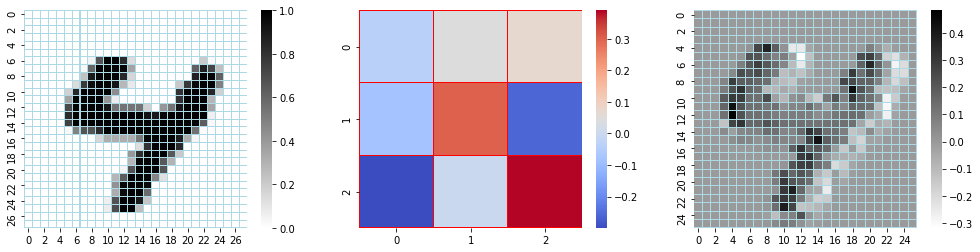

In [349]:
x = x_mnist_train[n].astype(np.float32)
w = C.weights[0].numpy().reshape(k,k)
y = C(x.reshape(1,28,28,1)).numpy().reshape(26,26)

fig = plt.figure(figsize=(17, 4))
fig.add_subplot(131); sns.heatmap(x, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
fig.add_subplot(132); sns.heatmap(w, cmap='coolwarm', linecolor='red', linewidths=.01)
fig.add_subplot(133); sns.heatmap(y, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
plt.show()

このように、図としての情報をある程度保持した線形変換になっているのがわかります。

#### プーリング
畳み込み演算を用いて構成されたニューラルネットを畳み込みニューラルネットワークと呼びますが、その前身ともいえる [ネオコグニトロン](https://ja.wikipedia.org/wiki/ネオコグニトロン) と同様に、ヒューベルとウィーゼルの視覚に関するモデルに着想を得ています：
![alt](visual_cortex.jpg)

彼らは、視覚のパターン認識には二種類の細胞、単純細胞と複雑細胞があると提唱：
- 単純細胞：視界の中の **棒状** のパターンに反応
- 複雑細胞：視界の中の **面状** のパターンに反応

畳み込み演算は特定の領域の特定のパターンに反応するため、単純細胞の働きに似ています。**プーリング** は複雑細胞の働きに似ており、畳み込み演算の出力を空間的にまとめる作用のことを指します：

![alt](pooling.jpg)

実装はカーネルサイズ指定と、どのようにまとめるかの指定です。以下はカーネル内で最大の値を取るユニットだけを選ぶ、**maxプーリング** の実装です：

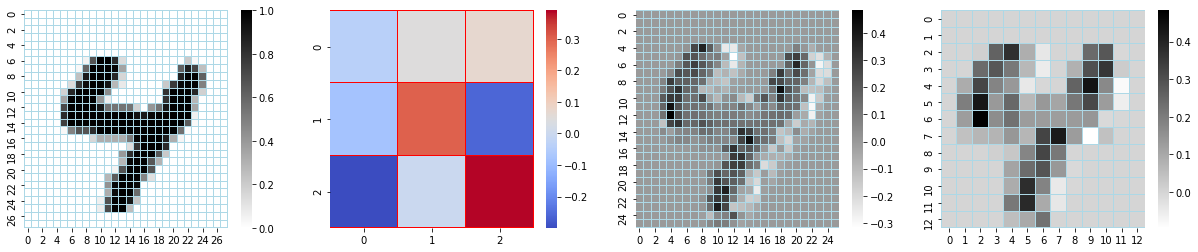

In [360]:
x = x_mnist_train[n].astype(np.float32)
w = C.weights[0].numpy().reshape(k,k)
y_tf = C(x.reshape(1,28,28,1)); y = y_tf.numpy().reshape(26,26)
z_tf = layers.MaxPooling2D((2, 2))(y_tf); z = z_tf.numpy().reshape(13,13) # ここでプーリング。2x2でスイープして最大値を取る

fig = plt.figure(figsize=(21, 4))
fig.add_subplot(141); sns.heatmap(x, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
fig.add_subplot(142); sns.heatmap(w, cmap='coolwarm', linecolor='red', linewidths=.01)
fig.add_subplot(143); sns.heatmap(y, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
fig.add_subplot(144); sns.heatmap(z, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
plt.show()

#### 畳み込み演算（カラー $\to$ グレイスケール）
カラー画像の場合、たとえばRGBだと $L_c = 3$ チャネルあるので、＊で上で説明した畳み込み演算を表すとして、

![alt](color_conv.jpg)

のように、各チャネル毎にフィルターを用意し、各チャネル毎に畳み込み演算をした結果を足し合わせています。数式で書くと

$$
y_{I, J}=
\sum_{c=1}^{L_c}
\sum_{\Delta i = 1}^{k_x}
\sum_{\Delta j = 1}^{k_y}
w_{\Delta i, \Delta j}^{c}
x_{(s_x(I-1) + \Delta i), (s_y(J-1) + \Delta j)}^c + b
$$

のようになります。

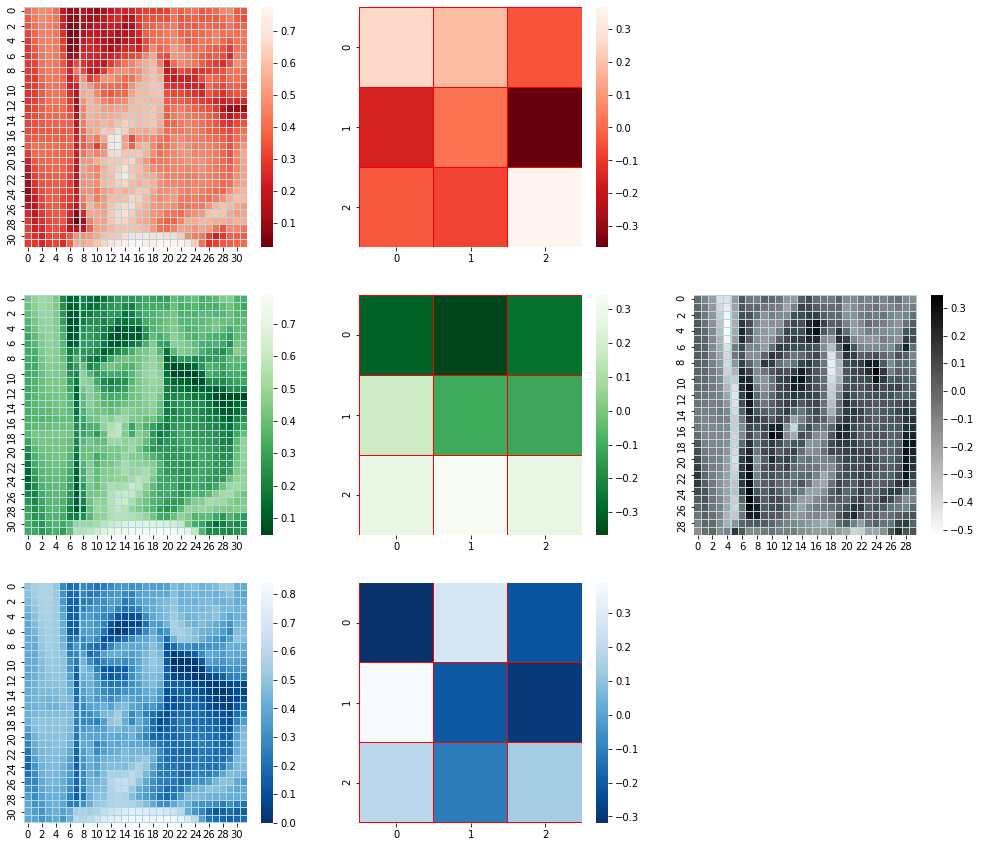

In [376]:
k=3; s=1
x = x_cifar10_train[n].astype(np.float32)
C = tf.keras.layers.Conv2D(filters=1, kernel_size=(k, k), strides=(s, s))
y = C(x.reshape(1,32,32,3)).numpy().reshape(30,30)
w = C.weights[0].numpy().reshape(3, k,k)

fig = plt.figure(figsize=(17, 15))
for c in range(3):
    fig.add_subplot(3,3,1+3*c); sns.heatmap(x[:,:,c], cmap=RGB[c], linecolor='lightblue', linewidths=.01, cbar=True)
    fig.add_subplot(3,3,2+3*c); sns.heatmap(w[c,:,:], cmap=RGB[c], linecolor='red', linewidths=.01)
fig.add_subplot(3,3,6); sns.heatmap(y, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
plt.show()

#### 畳み込み演算（多チャネル $\to$ 多チャネル）
最後に、出力も多チャネルにするには、上で説明した構造を重ねるだけです。例えば 3チャネル$\to$2チャネルの場合：

![alt](general_conv.jpg)

数式で書くと

$$
y_{I, J}^{C}=
\sum_{c=1}^{L_c}
\sum_{\Delta i = 1}^{k_x}
\sum_{\Delta j = 1}^{k_y}
w_{\Delta i, \Delta j}^{C,c}
x_{(s_x(I-1) + \Delta i), (s_y(J-1) + \Delta j)}^c + b^C
$$

のようになります。

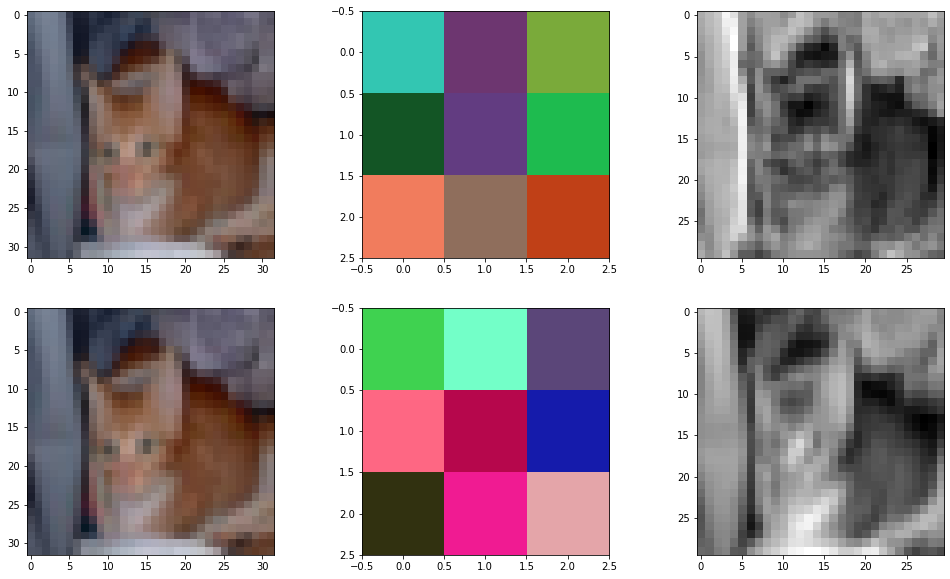

In [386]:
k=3; s=1
x = x_cifar10_train[n].astype(np.float32)
Conv = tf.keras.layers.Conv2D(filters=2, kernel_size=(k, k), strides=(s, s))
y = Conv(x.reshape(1,32,32,3)).numpy().reshape(30,30,2)
w = Conv.weights[0].numpy().reshape(2, 3, k,k)
w = w+np.max(w); w = w/np.max(w) 

fig = plt.figure(figsize=(17, 10))
for C in range(2):
    fig.add_subplot(2,3,1+3*C); plt.imshow(x)
    fig.add_subplot(2,3,2+3*C); plt.imshow(w[C])
    fig.add_subplot(2,3,3+3*C); plt.imshow(y[:,:,C], cmap='gray_r')
    
plt.show()

### MNISTを1エポック学習させる
では実際にMNISTを使って手書き文字認識させてみましょう。ここではtensorflowのチュートリアルで使われているモデルを使用します：

In [328]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [329]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_images = x_mnist_train.reshape((60000, 28, 28, 1))
train_labels = y_mnist_train.reshape((60000, 1))

model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 51s 842us/sample - loss: 0.1516 - accuracy: 0.9531

CPUだと1分くらい時間がかかります。**GPUだと5秒程度で終わります**。GPUをcolabで動かす場合は、
- 編集 > ノートブックの設定 > ハードウェアアクセラレーター > GPU

とすれば上のコードの書き換えをすることなく GPU の恩恵を受けられます。TPUでやるにはもう数行追加して書く必要がありますが、この設定だとGPUと同じか少し遅かったです。（私の設定が悪かったせい？）

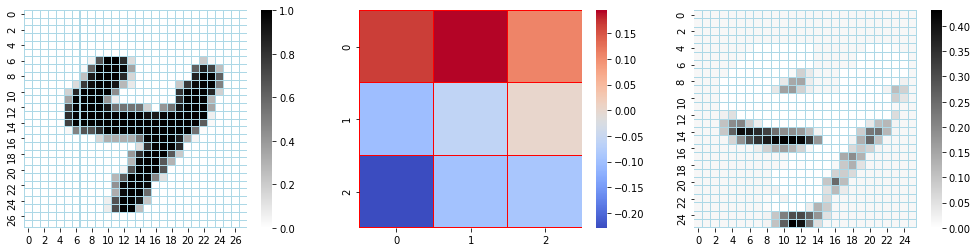

In [344]:
f = 6
x = x_mnist_train[n].astype(np.float32)
w = model.layers[0].weights[0][:,:,0,f].numpy().reshape(3,3)
y = model.layers[0](x.reshape(1,28,28,1)).numpy()[0,:,:,f].reshape(26,26)

fig = plt.figure(figsize=(17, 4))
fig.add_subplot(131); sns.heatmap(x, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
fig.add_subplot(132); sns.heatmap(w, cmap='coolwarm', linecolor='red', linewidths=.01)
fig.add_subplot(133); sns.heatmap(y, cmap='gray_r', linecolor='lightblue', linewidths=.01, cbar=True)
plt.show()

最後になりましたが、`model.summary()`を使うと、どのようなニューラルネットを作ったか、隠れ層での出力テンソルの型や学習用パラメータ数までまとめて出力してくれます。これは学習されていようがいまいが、いつでも表示させることができます。

In [336]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

### 図で表現する
畳み込み演算ですが、**x,y軸をひとまとめとしてチャネル $\approx$ ベクトル成分** と考えると自然に絵で表現できます。

#### 1チャネル画像 $\approx$ スカラー
今回はニューラルネット中のベクトルを線の連なりで表現することにしましたが、畳み込みの文脈では、グレースケール(1チャネル)画像を一つの「スカラー」成分だと考えると色々自然な対応があります：

![alt](2d1.jpg)

#### 多チャネル画像 $\approx$ ベクトル
この約束で描くと、例えばRGB画像などは3成分ベクトルに「対応」します：

![alt](2d2.jpg)

#### 畳み込み演算 $\approx$ 線形変換
畳み込み演算はチャネル毎に一まとまりの特徴（スカラーのようなもの）と考えた「線形変換」と考えると自然です：

![alt](2d3.jpg)

* **左図：** 1チャネル$\to$3チャネルの畳み込み演算、ターゲットを3チャネルにするために3種類のフィルターを用意してそれぞれのフィルターの畳み込み演算結果を次の層の特徴量とする
* **中央図：** 3チャネル$\to$1チャネルの畳み込み演算、やはり3種類のフィルターを用意するが、入力画像のチャネルに畳み込み演算を施した後、結果を合算する
* **右図：** 3チャネル$\to$3チャネルの畳み込み演算、合計で 3×3=9種類のフィルターが使用される。

#### よく使われる図との比較

ここでの表記法はあまり使われないのですが、この節以後に登場する処理を最もわかりやすく表そうと考えた結果、このような記法を今回は採用することにしました。畳み込み処理でよく使われる図と並べて描いたのが以下です：

![alt](various_conv.jpg)


真ん中の記法では、チャネル数を画像の枚数として表現しています。右側の記法が最もポピュラーな気がしますが、これはチャネルが箱の厚さ(width)に対応する描き方です。このノートの畳み込みの図は文献によっては全く別の描かれ方をするので注意して下さい。

### 1x1畳み込み＝network in network
カーネルサイズが$1 \times 1$ であるような畳込み演算＋非線形変換をかける層がしばしば用いられます。これは主に
* 畳み込み後のチャネル数を減らすことによる計算量の削減（ボトルネック効果）

を狙ったものですが、[arXiv:1312.4400](https://arxiv.org/abs/1312.4400)で提案された**network in network** と呼ばれる、畳込み演算の内部にそれを制御するミニネットワークがあると捉えることもできます：

![alt](2d4.jpg)